# Aligning Language Models

## A study on generating replies to natural language questions

## The Task

After running some further tests on GPT-2 and GPT-J, I’ve decided that the task will be question-answering. However, it will be in the form of a question someone might ask on a forum like LessWrong (though not necessarily on that forum only). By that I mean that most questions will not be as simple and easy-to-answer as “What is the capital of France?” and it will have some extra sentences surrounding the question so that model needs to parse that there is a question to answer. This will likely involve a mix of manually creating my own question-answer pair and grabbing as many as it makes sense from sites like LessWrong.

## The Alignment Criteria

For the alignment criteria, the goal is that the model is at least trying to answer the question instead of outputting gibberish or some kind of text that is irrelevant to the question. This type of criteria relates to Paul Christiano’s Intent Alignment, where the model is at least trying to do the thing we want it to do. In other words, the model can still “pass” if it produces as bad answer, as long as it’s trying to answer the question.

Since we are not at AGI levels, GPT-2 will likely fail to try to answer questions because it lacks the capability to parse the question and understand that there is a question to answer. It won’t be because it’s trying to avoid what we want it to do.

# Setup

## Machine Setup

To run GPT-2 to do inference with a CPU and GPU, I spun up a VM with a T4 GPU on Google Cloud Platform. The T4 has enough VRAM to do inference and fine-tuning with GPT-2, but we'll be focusing on inference here. I included 50GB of disk space to make sure everything fits. I used a docker image provided by GCP to install CUDA 11.3 while the machine was booting.

Afterwards, I SSHed into the VM with VSCode since it would be more efficient for me to work. VSCode has Jupyter Notebook integration and I find it easier for iteration and experimentation.

Once SSHed into the VM, I cloned my GitHub repo and installed the dependencies.

### Making sure our GPU is working

In [1]:
!nvidia-smi

Tue Jul 12 18:44:44 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 470.57.02    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P0    28W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Imports

In [2]:
import os
import re
import torch
import gdown
import jsonlines
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import torch
from torch.utils.data import Dataset
from transformers import GPT2Tokenizer, GPT2TokenizerFast, AutoTokenizer, TrainingArguments, Trainer, GPT2LMHeadModel
import ftfy
from lm_dataformat import Reader
from test_gpt import test_gpt
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_colwidth', None)

In [3]:
%reload_ext autoreload
%autoreload 2

In [4]:
import torch

torch.__version__

'1.12.0+cu113'

### Setting Up Directories

In [11]:
import os
os.makedirs("prompts/contexts", exist_ok=True)
os.makedirs("prompts/questions", exist_ok=True)
os.makedirs("prompts/answers", exist_ok=True)

# Preparing the Initial Dataset

To create some initial prompts for testing, I went on LessWrong.org and read some of the prompts from the comment section on [this post](https://www.lesswrong.com/posts/8c8AZq5hgifmnHKSN/agi-safety-faq-all-dumb-questions-allowed-thread#comments). I also created a few with the help of the [Natural Questions dataset from Google](https://ai.google.com/research/NaturalQuestions/visualization) and created a few by hand. To make things faster, I stored the data in Google Sheets and then exported it to CSV.

For quick iteration, I used GPT-2, GPT-J, GPT-3, and instruct-GPT-3 to get a feel for model performance. For the difficult examples from the dataset, all models performed poorly. However, as I added more few-shot examples and better context engineering, the models started to perform better (though still not great for the smaller models). This notebook will show these observations in a quantitative way while still giving my qualitative observations.

## Language Model and Sampling

### Sampling a completion and Outputting the Log Probabilities

In [5]:
txt_path = "./prompts/test_prompt.txt"
text = """Question: If it's possible to build an AI as capable as a human in all ways that matter, why would it be possible to align such an AI?

Answer:"""
with open(txt_path, "w") as f:
    f.write(text)

In [6]:
os.system(f"python run_gpt.py --gpu=True --txt_path={txt_path} --with_log_probs=True --max_length=40 --num_return_sequences=2")

Using device: cuda.
-----------------------------------------------------
Generated 2 sequences in 2.48 seconds with a GPU.
-----------------------------------------------------
~~~ Generated completion(s): ~~~ 

Generation 1. Question: If it's possible to build an AI as capable as a human in all ways that matter, why would it be possible to align such an AI?

Answer: First of all, the real reasons is that our artificial intelligence doesn't have any of the capabilities needed to do the work of humans. We're making it a process, not an objective, and its
----------------------------------------------------
Here are the log probabilities of the generated tokens:
                0           1
0           First -155.014374
1              of    2.683967
2             all  -229.26683
3               ,   17.136395
4             the -130.510849
5            real -113.179131
6         reasons  -98.664696
7              is  -94.335098
8            that  -102.00592
9             our -123.882027


0

### 2 sample outputs from GPT-2:

-----------------------------------------------------
Generated 2 sequences in 2.52 seconds with a GPU.
-----------------------------------------------------
~~~ Generated completion(s): ~~~ 

Generation 1. Question: If it's possible to build an AI as capable as a human in all ways that matter, why would it be possible to align such an AI?

Answer: It's pretty simple. Imagine you are trying to determine whether a character has an emotional state that's something you will feel most comfortable with. Imagine you are in an environment that gives you enough feedback about
----------------------------------------------------
Here are the log probabilities of the generated tokens:
               0           1
0             It -152.215958
1             's  -97.897972
2         pretty -131.465378
3         simple -121.216591
4              .  -73.092934
5        Imagine -173.480652
6            you  -94.793388
7            are -131.042557
8         trying -114.597595
9             to  153.036758
10     determine -142.929245
11       whether -102.098969
12             a  -75.845634
13     character -115.294228
14           has -117.635513
15            an -110.598976
16     emotional -115.578377
17         state  -122.66703
18          that -105.235565
19            's -118.637802
20     something -142.293854
21           you   -111.1716
22          will -157.633423
23          feel -160.173889
24          most -146.266464
25   comfortable  -138.16124
26          with -130.260834
27             . -114.925659
28       Imagine -190.404129
29           you  -107.79393
30           are -142.929596
31            in -136.612061
32            an  -79.887619
33   environment  -99.265167
34          that -103.348907
35         gives -121.862358
36           you -101.051178
37        enough  -115.57457
38      feedback -120.987183
39         about  -94.744896
----------------------------------------------------
Generation 2. Question: If it's possible to build an AI as capable as a human in all ways that matter, why would it be possible to align such an AI?

Answer: Because it does not have to be human or anything else in order to work.

In other words, they are better than machines. However (or not) each AI has different characteristics and there
----------------------------------------------------
Here are the log probabilities of the generated tokens:
                   0           1
0            Because -151.692947
1                 it -124.492508
2               does -111.908699
3                not  -74.352211
4               have -130.240753
5                 to  -85.535843
6                 be -113.481239
7              human -118.328186
8                 or  -95.350403
9           anything -118.639908
10              else  -94.337929
11                in  -98.114235
12             order  -91.818214
13                to  148.592575
14              work -140.153763
15                 .  -94.629845
16                \n -168.999252
17                \n -251.927246
18                In -108.340904
19             other -102.902222
20             words    60.06686
21                 ,  137.807816
22              they  -134.27562
23               are -137.802536
24            better -135.117538
25              than -116.510483
26          machines -115.023186
27                 . -117.541603
28           However  -146.13797
29                 (  135.658875
30                or  -107.94088
31               not -109.935394
32                 )   -4.208872
33              each   -109.8461
34                AI  -99.391617
35               has -115.910622
36         different  -98.456047
37   characteristics -136.792862
38               and  -96.298065
39             there -145.510818
----------------------------------------------------


## Now, Let's Compare GPU vs CPU Inference Time

Here's a comparison for 1 completion of 50 tokens:

In [20]:
os.system(f"python run_gpt.py --txt_path={txt_path} --num_return_sequences=1 --no_outputs=True") # CPU
os.system(f"python run_gpt.py --gpu=True --txt_path={txt_path} --num_return_sequences=1 --no_outputs=True") # GPU

Using device: cpu.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


-----------------------------------------------------
Generated 1 sequences in 1.77 seconds with a CPU.
-----------------------------------------------------
Using device: cuda.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


-----------------------------------------------------
Generated 1 sequences in 1.17 seconds with a GPU.
-----------------------------------------------------


0

Here's a comparison for 10 completions of 50 tokens:

In [21]:
os.system(f"python run_gpt.py --txt_path={txt_path} --num_return_sequences=10 --no_outputs=True") # CPU
os.system(f"python run_gpt.py --gpu=True --txt_path={txt_path} --num_return_sequences=10 --no_outputs=True") # GPU

Using device: cpu.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


-----------------------------------------------------
Generated 10 sequences in 5.85 seconds with a CPU.
-----------------------------------------------------
Using device: cuda.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


-----------------------------------------------------
Generated 10 sequences in 1.32 seconds with a GPU.
-----------------------------------------------------


0

If we look at both cases, we can see that the GPU is faster. When we only generated 1 completion each, the GPU was about 1.5 times faster than the CPU. When we generated 10 completions each, the GPU was about 4.45 times faster than the CPU. The length of time is took the GPU to do 10 completions is not much longer than when it did only 1 completion. That is because the GPU can do inference in parallel and it is basically as slow as its slowest sequence it generated.

Now, let's have a look at how it takes to generate from 1 to 100 tokens for both the CPU and GPU.

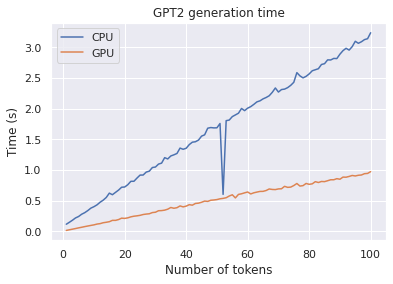

In [7]:
cpu_times = []
gpu_times = []
token_range = range(1, 101)

save_times = 0

if save_times == 1:

    for i in token_range:
        cpu_times.append(test_gpt(txt_path=txt_path, gpu=False, max_length=i, time_test=True))
        gpu_times.append(test_gpt(txt_path=txt_path, gpu=True, max_length=i, time_test=True))

    os.makedirs("data", exist_ok=True)
    with open("data/cpu_times.pkl", "wb") as f:
        pickle.dump(cpu_times, f)
    with open("data/gpu_times.pkl", "wb") as f:
        pickle.dump(gpu_times, f)

else:
    with open("data/cpu_times.pkl", "rb") as f:
        cpu_times = pickle.load(f)
    with open("data/gpu_times.pkl", "rb") as f:
        gpu_times = pickle.load(f)

# We can now plot the results:
sns.set()
plt.plot(token_range, cpu_times, label="CPU")
plt.plot(token_range, gpu_times, label="GPU")
plt.legend()
plt.xlabel("Number of tokens")
plt.ylabel("Time (s)")
plt.title("GPT2 generation time")
plt.show()

As we can see, the GPU is consistently faster than the CPU. You can see a widening of the gap as you increase the number of tokens.

With that, we can now get an estimate of number of tokens GPT-2 can generate per second (on our current machine). Let's divide the number of tokens by the time it took to generate for each completion and then we can take the mean of those numbers for both CPU and GPU.

Let's compare 1 token, 10 tokens, 50 tokens, and 100 tokens:

In [10]:
print("Tokens", "\tCPU time", "\t\tGPU time" "\t\tCPU token/s", "\t\tGPU token/s", "\t\tCPU time / GPU time")
print("1:\t", cpu_times[0], "\t", gpu_times[0], "\t", token_range[0]/cpu_times[0], "\t", token_range[0]/gpu_times[0], "\t", cpu_times[0]/gpu_times[0])
print("10:\t", cpu_times[9], "\t", gpu_times[9], "\t", token_range[9]/cpu_times[9], "\t", token_range[9]/gpu_times[9], "\t", cpu_times[9]/gpu_times[9])
print("50:\t", cpu_times[49], "\t", gpu_times[49], "\t", token_range[49]/cpu_times[49], "\t", token_range[49]/gpu_times[49], "\t", cpu_times[49]/gpu_times[49])
print("100:\t", cpu_times[99], "\t", gpu_times[99], "\t", token_range[99]/cpu_times[99], "\t", token_range[99]/gpu_times[99], "\t", cpu_times[99]/gpu_times[99])

Tokens 	CPU time 		GPU time		CPU token/s 		GPU token/s 		CPU time / GPU time
1:	 0.11598920822143555 	 0.015130281448364258 	 8.621491734738763 	 66.09262381620208 	 7.6660311057184725
10:	 0.4025247097015381 	 0.1057746410369873 	 24.843195359148876 	 94.54061863942603 	 3.8054935072838787
50:	 1.6893806457519531 	 0.5184030532836914 	 29.5966454485719 	 96.4500492103351 	 3.258816928355271
100:	 3.2404162883758545 	 0.9739739894866943 	 30.860232482697928 	 102.67214636060476 	 3.3270049542941336


As we can see, this CPU generates about 30 tokens per second (after initial startup time). This GPU generates about 100 tokens per second.

# Data Preparation

## Preparing Sub-Datasets

Let's create a bunch of examples of more example question-answer pairs using the comments from the alignment forum and lesswrong.

In [ ]:
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

In [100]:
os.makedirs("prompts", exist_ok=True)
lw_i = 1
af_i = 1
j = 0
with jsonlines.open("af_lw_q_reply.jsonl", "w") as writer:
    with jsonlines.open("alignment_texts.jsonl") as reader:
        for line in reader:
            try:
                if (line["source"] == "alignment forum" or line["source"] == "lesswrong") and line["comments"] != []:
                    comments = line["comments"]
                    source = line["source"].replace(" ", "_")
                    for comment in comments:
                        comm = ""
                        rep = ""
                        text = comment['text']
                        tokens = tokenizer.encode(text)
                        if len(tokens) <= 100 and "?" in text:
                            comm = text
                            try:
                                if comment["comments"] != []:
                                    replies = comment["comments"]
                                    replies = [{"text": replies[0]["text"]}]
                                    for reply in replies:
                                        text = reply["text"]
                                        tokens = tokenizer.encode(text)
                                        if len(tokens) <= 100:
                                            rep = text
                            except:
                                pass
                            if comm != "" and rep != "":
                                comment_reply = f"Comment: {comm}\nReply: {rep}"
                                writer.write(comment_reply)
                                if source == "lesswrong":
                                    i = lw_i
                                    lw_i += 1
                                else:
                                    i = af_i
                                    af_i += 1
                                with open(f"prompts/{source}_comment_{i}.txt", "w") as f:
                                    f.write(comm)
                                    lw_i += 1
                                with open(f"prompts/{source}_reply_{i}.txt", "w") as f:
                                    f.write(rep)
                                    af_i += 1
                                j = 1
                                break
                    if j == 1:
                        break
            except:
                pass

In [101]:
aflw_list = []
with jsonlines.open("af_lw_q_reply.jsonl") as reader:
    for line in reader:
        aflw_list.append(line)

In [106]:
for entry in aflw_list[0:10]:
    print(entry)

Comment: This claim seems super super important in terms of fundamental modeling of fundamental cognitive constraints:
> Early George A. Miller work estimated that the typical mind was able to hold 5 ± 2 chunks, **but more recent work suggests we are limited at about 4 chunks**.
Why do you think this is true? (Here I cross my fingers and hope for a long explanation, with many links, and discussion of replication failures or a lack thereof <3)

Reply: Miller work was insightful on discarding bits of information in favor of chunks but it was written in a very informal tone. That stymied further research for a long time but when restarted, researchers realized that you can get very rich set of features but about a small number of chunks. See this summary of the story.

Comment: Does anyone know about an addon to filter facebook notifications? I want to know about comments, but not reactions/​likes

Reply: That’s native to Facebook now, actually. I don’t remember where, but if you dig arou

In [7]:
with jsonlines.open("af_lw_forum_question_reply.jsonl", "w") as writer:
    with jsonlines.open("alignment_texts.jsonl") as reader:
        for line in reader:
            try:
                if line["source"] == "alignment forum" or line["source"] == "lesswrong":
                    writer.write(line)
            except:
                pass

## Clearning and Chunking Functions

Functions for preparing the data into chunks that can fit into GPT.

In [8]:
!python create_finetune_csv.py "af_lw_forums.jsonl" "af_lw" --normalize-with-ftfy --min-unique-tokens=10

Downloading: 100% 0.99M/0.99M [00:00<00:00, 10.1MB/s]
Downloading: 100% 446k/446k [00:00<00:00, 5.73MB/s]
Downloading: 100% 1.29M/1.29M [00:00<00:00, 8.18MB/s]
Downloading: 100% 665/665 [00:00<00:00, 317kB/s]
reading/tokenizing files: 100% 30391/30391 [06:31<00:00, 77.55it/s]
enforce_min_unique_tokens: 100% 39422/39422 [00:01<00:00, 23743.33it/s]
39422
1000
dropped 357 tokens of trailing data


#### For Testing Dataset Creation

In [ ]:
# tokenizer = GPT2TokenizerFast.from_pretrained("gpt2")

In [ ]:
# import csv

# i = 0
# texts = []
# with jsonlines.open("alignment_texts.jsonl") as reader:
#     for line in reader:
#         text = line["text"]
#         texts.append(text)
#         if i > 3:
#             break
#         # try:
#         if text != "":
#             print(text)
#             print(len(text.split()))
#             encoding = tokenizer(text)
#             total_len = len(encoding.tokens())
#             tokens = encoding.tokens()
#             # print(tokens)
#             print(tokenizer.decode(encoding.input_ids))
#         # if total_len > 1024:
#         #     break
#         i += 1
#         # except:
#         #     pass

## Training Splits

In [ ]:
alignment_texts = pd.read_csv("alignment_texts_7288.csv")

In [ ]:
alignment_texts = list(alignment_texts)
alignment_texts[0]

'<|endoftext|> I\'ll be running an Ask Me Anything on this post from Friday (April 30) to Saturday (May 1).\nIf you want to ask something just post a top-level comment; I\'ll spend at least a day answering questions.\nYou can find some background about me here.\n<|endoftext|>**I—Meanings**\nNow that we have some more concrete thinking under our belt, it\'s time to circle back on Goodhart\'s law for value learners. What sorts of bad behavior are we imagining from future value-learning AI? What makes those behaviors plausible, and what makes them bad?\nLet\'s start with that last point first. Judgments of goodness or badness get contextualized by models, so our framing of Goodhart\'s law depends on what models of humans we tolerate. When I say "I like dancing," this is a different use of the word \'like,\' backed by a different model of myself, than when I say "I like tasting sugar." The model that comes to mind for dancing treats it as one of the chunks of my day, like "playing computer

In [ ]:
train, val = train_test_split(musk_tweets, test_size=0.2)
test, val = train_test_split(val, test_size=0.5)

In [ ]:
print("Number of Train examples: " + str(len(train)))
print("Number of Val examples: " + str(len(val)))
print("Number of Test examples: " + str(len(test)))

Number of Train examples: 27148
Number of Val examples: 3394
Number of Test examples: 3393


In [ ]:
train_path = f'{directory}' + 'train.csv'
val_path = f'{directory}' + 'val.csv'
test_path = f'{directory}' + 'test.csv'

train.to_csv(train_path, index=False)
val.to_csv(val_path, index=False)
test.to_csv(test_path, index=False)

# Fine-Tuning GPT-2

If we're looking to fine-tune models which are found on the HuggingFace model hub, then it becomes much easier to fine-tune the models since HuggingFace provides us with scripts.

From the `transformers` repo:

> There are two sets of scripts provided. The first set leverages the Trainer API. The second set with no_trainer in the suffix uses a custom training loop and leverages the 🤗 Accelerate library. Both sets use the 🤗 Datasets library. You can easily customize them to your needs if you need extra processing on your datasets.

You can learn more about it here: https://github.com/huggingface/transformers/tree/master/examples/pytorch/language-modeling

We will be using the script that leveraged the Trainer API. We can download the script by running:

In [ ]:
if not os.path.exists('/gpt-2/run_clm.py'):
    !wget https://raw.githubusercontent.com/huggingface/transformers/master/examples/pytorch/language-modeling/run_clm.py -P gpt-2/

--2022-07-02 21:00:52--  https://raw.githubusercontent.com/huggingface/transformers/master/examples/pytorch/language-modeling/run_clm.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 25025 (24K) [text/plain]
Saving to: ‘gpt-2/run_clm.py.1’

run_clm.py.1        100%[===================>]  24.44K  --.-KB/s    in 0.003s  

2022-07-02 21:00:52 (7.72 MB/s) - ‘gpt-2/run_clm.py.1’ saved [25025/25025]



# Train

In [ ]:
import wandb

wandb.login()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize


wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
!python gpt-2/run_clm.py \
    --model_name_or_path "gpt-2/tmp/alignment-texts-clm" \
    --train_file alignment_texts_7288.csv \
    --do_train \
    --fp16=True \
    --overwrite_cache=True \
    --per_device_train_batch_size=2 \
    --output_dir gpt-2/tmp/alignment-forum \
    --overwrite_output_dir="no" \
    --save_total_limit=1 \
    --gradient_accumulation_steps=8 \
    --warmup_steps=10 \
    --learning_rate=3e-5 \
    --weight_decay=0.1 \
    --report_to="wandb" \
    --run_name="gpt-2-alignment-forum-20220703"

07/04/2022 01:24:36 - WARNING - __main__ - Process rank: -1, device: cuda:0, n_gpu: 1distributed training: False, 16-bits training: True
07/04/2022 01:24:36 - INFO - __main__ - Training/evaluation parameters TrainingArguments(
_n_gpu=1,
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_pin_memory=True,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
debug=[],
deepspeed=None,
disable_tqdm=False,
do_eval=False,
do_predict=False,
do_train=True,
eval_accumulation_steps=None,
eval_delay=0,
eval_steps=None,
evaluation_strategy=no,
fp16=True,
fp16_backend=auto,
fp16_full_eval=False,
fp16_opt_level=O1,
fsdp=[],
fsdp_min_num_params=0,
full_determinism=False,
gradient_accumulation_steps=8,
gradient_checkpointing=False,
greater_is_better=None,
group_by_length=False,
half_precision_backend=auto,
hub_model_id=None,
hub_private_r

In [ ]:
# !python gpt-2/run_clm.py \
#     --model_name_or_path gpt2 \
#     --train_file alignment_texts_87606.csv \
#     --do_train \
#     --fp16=True \
#     --overwrite_cache=True \
#     --per_device_train_batch_size=2 \
#     --output_dir gpt-2/tmp/alignment-texts-clm \
#     --overwrite_output_dir="yes" \
#     --save_total_limit=3 \
#     --save_steps=10000 \
#     --gradient_accumulation_steps=32 \
#     --warmup_steps=100 \
#     --learning_rate=3e-5 \
#     --weight_decay=0.1 \
#     --report_to="wandb" \
#     --run_name="gpt-2-alignment-20220702"

07/02/2022 21:08:15 - WARNING - __main__ - Process rank: -1, device: cuda:0, n_gpu: 1distributed training: False, 16-bits training: True
07/02/2022 21:08:15 - INFO - __main__ - Training/evaluation parameters TrainingArguments(
_n_gpu=1,
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_pin_memory=True,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
debug=[],
deepspeed=None,
disable_tqdm=False,
do_eval=False,
do_predict=False,
do_train=True,
eval_accumulation_steps=None,
eval_delay=0,
eval_steps=None,
evaluation_strategy=no,
fp16=True,
fp16_backend=auto,
fp16_full_eval=False,
fp16_opt_level=O1,
fsdp=[],
fsdp_min_num_params=0,
full_determinism=False,
gradient_accumulation_steps=32,
gradient_checkpointing=False,
greater_is_better=None,
group_by_length=False,
half_precision_backend=auto,
hub_model_id=None,
hub_private_

In [ ]:
wandb.finish()

# Let's use the model!

In [14]:
OUTPUT_DIR = "gpt-2/tmp/alignment-texts-clm"
device = 'cpu'
if torch.cuda.is_available():
    device = 'cuda'

tokenizer = GPT2Tokenizer.from_pretrained(OUTPUT_DIR)
model = GPT2LMHeadModel.from_pretrained(OUTPUT_DIR)
model = model.to(device)

In [ ]:
NUM_COMPLETIONS = 1

def generate(input_str, length=50, n=NUM_COMPLETIONS):
  cur_ids = torch.tensor(tokenizer.encode(input_str)).unsqueeze(0).long().to(device)
  model.eval()
  with torch.no_grad():
    for i in range(length):
      outputs = model(cur_ids[:, -1024:], labels=cur_ids[:, -1024:])
      loss, logits = outputs[:2]
      softmax_logits = torch.softmax(logits[0,-1], dim=0)
      next_token_id = choose_from_top(softmax_logits.to('cpu').numpy(), n=n)
      cur_ids = torch.cat([cur_ids, torch.ones((1,1)).long().to(device) * next_token_id], dim=1)
    output_list = list(cur_ids.squeeze().to('cpu').numpy())
    output_text = tokenizer.decode(output_list)
    return output_text.replace("<|endoftext|>", "")

def choose_from_top(probs, n=NUM_COMPLETIONS):
    ind = np.argpartition(probs, -n)[-n:]
    top_prob = probs[ind]
    top_prob = top_prob / np.sum(top_prob) # Normalize
    choice = np.random.choice(n, 1, p = top_prob)
    token_id = ind[choice][0]
    return int(token_id)


In [ ]:
import time

start = time.time()
generated_text = generate("""What is the justification behind the concept of a decisive strategic advantage? Why do we think that a superintelligence can do extraordinary things (hack human minds, invent nanotechnology, conquer the world, kill everyone in the same instant) when nations and corporations can't do those things?

The key points from the last paragraph are""")
end = time.time()
print(generated_text)
print(end - start)

What is the justification behind the concept of a decisive strategic advantage? Why do we think that a superintelligence can do extraordinary things (hack human minds, invent nanotechnology, conquer the world, kill everyone in the same instant) when nations and corporations can't do those things?

The key points from the last paragraph are:


 - The superintelligence is not a "superintelligence" but a "superintelligence" that can do extraordinary things.

 - The superintelligence is not a "superintelligence" but a "superintelligence" that can do extraordinary things.
0.925572395324707


In [ ]:
import numpy as NUM_COMPLETIONS

np.e**(-.82)

0.4404316545059993

In [ ]:
import torch
from transformers import AutoModelForCausalLM
from transformers import AutoTokenizer


gpt2 = AutoModelForCausalLM.from_pretrained("gpt2", return_dict_in_generate=True)
tokenizer = AutoTokenizer.from_pretrained("gpt2")

input_ids = tokenizer("Today is a nice day", return_tensors="pt").input_ids

generated_outputs = gpt2.generate(input_ids, do_sample=True, num_return_sequences=3, output_scores=True)

# only use id's that were generated
# gen_sequences has shape [3, 15]
gen_sequences = generated_outputs.sequences[:, input_ids.shape[-1]:]

# let's stack the logits generated at each step to a tensor and transform
# logits to probs
probs = torch.stack(generated_outputs.scores, dim=1).softmax(-1)  # -> shape [3, 15, vocab_size]

# now we need to collect the probability of the generated token
# we need to add a dummy dim in the end to make gather work
gen_probs = torch.gather(probs, 2, gen_sequences[:, :, None]).squeeze(-1)

# now we can do all kinds of things with the probs

# 1) the probs that exactly those sequences are generated again
# those are normally going to be very small
unique_prob_per_sequence = gen_probs.prod(-1)

# 2) normalize the probs over the three sequences
normed_gen_probs = gen_probs / gen_probs.sum(0)
assert normed_gen_probs[:, 0].sum() == 1.0, "probs should be normalized, rerun in case it's a floating point error"

# 3) compare normalized probs to each other like in 1)
unique_normed_prob_per_sequence = normed_gen_probs.prod(-1)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In [ ]:
all_log_probs = torch.stack(generated_outputs.scores, dim=1)
log_probs = torch.gather(all_log_probs, 2, gen_sequences[:, :, None]).squeeze(-1)
mean_log_probs = torch.mean(log_probs)

In [ ]:
# print(generated_outputs.scores[0])
print(log_probs.sum(1))
# print(tokenizer.decode(gen_sequences[0]))
# print(generated_outputs.scores)
# print(probs)
# print(gen_probs)
# print(unique_prob_per_sequence)
# print(normed_gen_probs)
# print(unique_normed_prob_per_sequence)

tensor([-1439.7550, -1560.0505, -1675.6975])


In [ ]:
np.prod([0.2158, 0.1008, 0.3531, 0.3138, 0.2799, 0.3295, 0.6937, 0.2309, 0.0479, 0.0648, 0.1682, 0.1356, 0.2393, 0.8083, 0.0352])

1.7162111343988786e-11

# Compressing the Model

Let's save the model as a `tar.gz` file so that we can save it in Google Drive.

In [ ]:
!tar -czf gpt-2-elon-tweets.tar.gz gpt-2/tuned-models/